# CENG 463 HW 1– Water Resource Risk Classification
**Start Date:**  
**Due Date:** Month Dayth, 2026

## Dataset Overview
The dataset utilized in this assignment originates from the World Resources Institute (WRI) – Aqueduct Water Risk Atlas. It provides country-level indicators describing key hydrological and environmental factors, which are listed in the table below. The objective is to classify each country into a Water Resource Risk Category (0-4) using these indicators. Students are also expected to create two derived features — Composite Water Stress Index (CWSI) and Seasonal–Flood Interaction (SFI).

| Feature | Description |
|---------|-------------|
| gid_0 | Country Code |
| bws_score | Baseline Water Stress |
| gtd_score | Groundwater Depletion |
| drr_score | Drought Risk |
| rfr_score | River Flood Risk |
| sev_score | Seasonal Variability |
| w_awr_def_tot_cat | Target: Water Risk Category (0-4) |


## 1. Feature Engineering (35 pts)
Students are expected to create two new features based on the existing indicators:

1. **Composite Water Stress Index (CWSI):**
   CWSI combines baseline water stress, groundwater depletion, and drought risk.
   Formula: CWSI = 0.5 × bws_score + 0.3 × gtd_score + 0.2 × drr_score

2. **Seasonal–Flood Interaction (SFI):**
   SFI represents interaction between seasonal variability and river flood risk.
   Formula: SFI = sev_score × rfr_score


In [1]:
# TODO: Create CWSI and SFI features
# df['CWSI'] = ...
# df['SFI'] = ...

import pandas as pd
import numpy as np


#load the dataset
df=pd.read_csv("water_risk_dataset.csv")

#new features, cwsi and sfi
df['CWSI'] =  0.5 * df['bws_score'] + 0.3 * df['gtd_score'] + 0.2 * df['drr_score']
df['SFI'] = df['sev_score'] * df['rfr_score']



## 2. Model Training & Evaluation (40 pts)
Train five classification models: Random Forest, SVM, KNN, Gaussian Naive Bayes, Logistic Regression.

*Hint: Use scaled data for SVM, KNN, Logistic Regression.*

In [2]:
# TODO: Split data into features X and target y

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#we drop gid and target columns from the features, because training with gid might cause to overfit and training with the target columns is basically cheating
X = df.drop(columns=['gid_0', 'w_awr_def_tot_cat'])
y = df['w_awr_def_tot_cat']

#cross validation, %80 training %20 test
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=42)
print("data splitted into train and test")

#scaled data for SVM, KNN, logistic regression
scaler = StandardScaler()
train_scaled_X = scaler.fit_transform(train_X)
test_scaled_X = scaler.transform(test_X)

data splitted into train and test


In [3]:
# TODO: Train models and evaluate accuracy

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# random forest (uses unscaled data)
rf = RandomForestClassifier(random_state=1923)
rf.fit(train_X, train_y)
rf_acc = accuracy_score(test_y, rf.predict(test_X))

# gaussian naivebayes (uses unscaled data)
nb = GaussianNB()
nb.fit(train_X, train_y)
nb_acc = accuracy_score(test_y, nb.predict(test_X))

# SVM (uses scaled data)
svm = SVC(random_state=1923)
svm.fit(train_scaled_X, train_y)
svm_acc = accuracy_score(test_y, svm.predict(test_scaled_X))

# KNN (uses scaled data)
knn = KNeighborsClassifier()
knn.fit(train_scaled_X, train_y)
knn_acc = accuracy_score(test_y, knn.predict(test_scaled_X))

# logistic regression (uses scaled data)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(train_scaled_X, train_y)
lr_acc = accuracy_score(test_y, lr.predict(test_scaled_X))

In [4]:
# TODO: Prepare evaluation table
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gaussian NB', 'SVM', 'KNN', 'Logistic Regression'],
    'Accuracy': [rf_acc, nb_acc, svm_acc, knn_acc, lr_acc]
})
print("Baseline Model Evaluation:")
display(results_df)

Baseline Model Evaluation:


,Model,Accuracy
0,Random Forest,0.914380
1,Gaussian NB,0.609221
2,SVM,0.756312
3,KNN,0.811196
4,Logistic Regression,0.687157


## 3. Hyperparameter Optimization (20 pts)
Tune each model using GridSearchCV with 5-fold CV.
Compare baseline and tuned results and report improvements.
Identify the model with highest tuned performance.

Hint: Use accuracy as scoring metric. Add classification report.

In [5]:
# TODO: Define parameter grids for each model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "Gaussian NB": {
        'var_smoothing': [1e-9, 1e-8]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs']
    }
}

#for easier access stored models in dict
models_map = {
    "Random Forest": rf,
    "Gaussian NB": nb,
    "SVM": svm,
    "KNN": knn,
    "Logistic Regression": lr
}

tuned_results = {}
best_estimators = {}

In [6]:
# TODO: Perform GridSearchCV and compare results

print("Starting Grid Search (this may take a moment)...")
#performing gridsearchcv
#for loop is a good idea for this
for name, model in models_map.items():
    #selecting the data for each model(scaled or unscaled)
    if name in ["SVM", "KNN", "Logistic Regression"]:
        tune_X = train_scaled_X
        val_X = test_scaled_X
    else:
        tune_X = train_X
        val_X = test_X
        
    #run Grid Search
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(tune_X, train_y)
    
    #save best model
    best_model = grid.best_estimator_
    best_estimators[name] = best_model
    
    #score on test set
    acc = accuracy_score(test_y, best_model.predict(val_X))
    tuned_results[name] = acc
    
    print(f"{name} - Best Params: {grid.best_params_} | Tuned Acc: {acc:.4f}")

#compare baseline and tuned
comparison_df = pd.DataFrame({
    'Model': results_df['Model'],
    'Baseline': results_df['Accuracy'],
    'Tuned': [tuned_results[m] for m in results_df['Model']]
})
comparison_df['Improvement'] = comparison_df['Tuned'] - comparison_df['Baseline']
print("\nHyperparameter Tuning Comparison:")
display(comparison_df)

#identify best model
best_model_name = comparison_df.loc[comparison_df['Tuned'].idxmax()]['Model']
print(f"\nBest Performing Model: {best_model_name}")

#classification report for the best model
final_model = best_estimators[best_model_name]
if best_model_name in ["SVM", "KNN", "Logistic Regression"]:
    final_preds = final_model.predict(test_scaled_X)
else:
    final_preds = final_model.predict(test_X)

print(classification_report(test_y, final_preds))

Starting Grid Search (this may take a moment)...
Random Forest - Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} | Tuned Acc: 0.9144
Gaussian NB - Best Params: {'var_smoothing': 1e-09} | Tuned Acc: 0.6092
SVM - Best Params: {'C': 10, 'kernel': 'rbf'} | Tuned Acc: 0.7816
KNN - Best Params: {'n_neighbors': 3, 'weights': 'distance'} | Tuned Acc: 0.8836
Logistic Regression - Best Params: {'C': 1, 'solver': 'lbfgs'} | Tuned Acc: 0.6872

Hyperparameter Tuning Comparison:


,Model,Baseline,Tuned,Improvement
0,Random Forest,0.914380,0.914380,0.000000
1,Gaussian NB,0.609221,0.609221,0.000000
2,SVM,0.756312,0.781559,0.025247
3,KNN,0.811196,0.883644,0.072448
4,Logistic Regression,0.687157,0.687157,0.000000



Best Performing Model: Random Forest
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       156
         1.0       0.88      0.92      0.90       165
         2.0       0.92      0.81      0.86       171
         3.0       0.88      0.91      0.89       194
         4.0       0.95      0.95      0.95       225

    accuracy                           0.91       911
   macro avg       0.91      0.91      0.91       911
weighted avg       0.91      0.91      0.91       911



## 4. Feature Importance Analysis (5 pts)
Choose one model and analyze feature importance. Present most influential features in a table and bar chart.


Feature Importance Table:


,Feature,Importance
0,CWSI,0.299885
1,drr_score,0.157159
2,bws_score,0.150988
3,gtd_score,0.141113
4,SFI,0.094131
5,rfr_score,0.079914
6,sev_score,0.076810


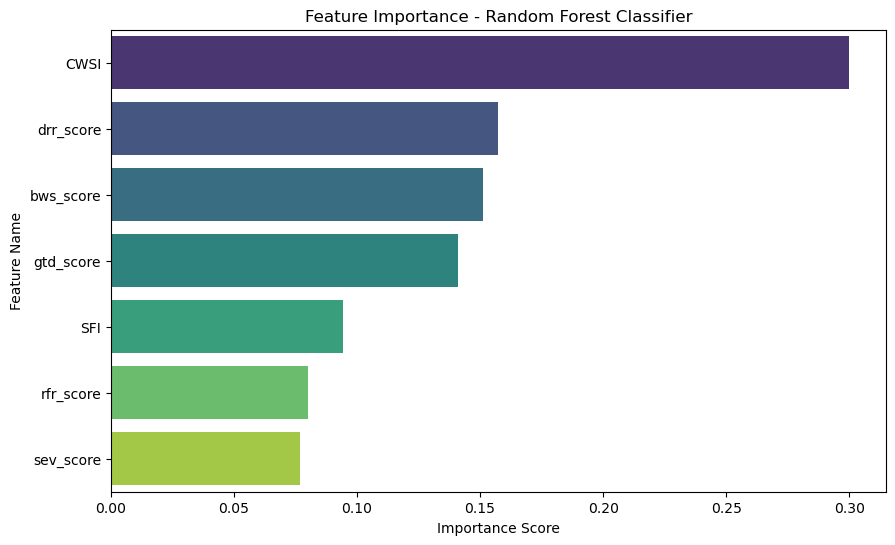


--- Analysis ---
The most influential features in predicting Water Risk are: CWSI, drr_score, bws_score.
Interpretation: The model relies heavily on these indicators to classify the risk category.
Notably, check if your derived features (CWSI or SFI) appear at the top,
as this would confirm that your feature engineering in Task 1 added value.


In [ ]:
# TODO: Select your best model (Random Forest)
#we access the best estimator
best_rf_model = best_estimators['Random Forest']

# Ensure the model is fitted (it should be from GridSearch, but this is a safety check)
# If for some reason best_estimators is empty, we retrain a basic version
if best_rf_model is None:
    best_rf_model = RandomForestClassifier(random_state=42)
    best_rf_model.fit(train_X, train_y)

# TODO: Calculate feature importances
importances = best_rf_model.feature_importances_
feature_names = train_X.columns

# TODO: Create a table of features sorted by importance
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

#sort by importance in descending order
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nFeature Importance Table:")
display(feature_imp_df)

# TODO: Plot a bar chart of feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, hue='Feature', palette='viridis', legend=False)

plt.title('Feature Importance - Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

# TODO: Optional: Comment on top 3-5 most influential features
print("\n--- Analysis ---")
top_features = feature_imp_df['Feature'].head(3).tolist()
print(f"The most influential features in predicting Water Risk are: {', '.join(top_features)}.")
print("Interpretation: The model relies heavily on these indicators to classify the risk category.")
print("Notably, check if your derived features (CWSI or SFI) appear at the top,")
print("as this would confirm that your feature engineering in Task 1 added value.")